In [60]:
from bs4 import BeautifulSoup
import pandas as pd
import pickle
import numpy as np
import missingno as msno
import time, re
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

In [18]:
gecko = pd.read_csv("gecko_final_7.csv")
total_crypto_mkt_cap = 1521620816260
url = "https://www.coingecko.com/en/coins/bscshiba"
USER_AGENT = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.77 Safari/537.36"
headers = {'user-agent': USER_AGENT}

print(f"Scraping {url}\n")
response = requests.get(url, headers=headers)
print(response.status_code)
coin_html_text = response.text
coin_soup = BeautifulSoup(coin_html_text, 'lxml')

gecko.head()

Scraping https://www.coingecko.com/en/coins/bscshiba

200


,name,symbol,price,volume,mkt_cap,coingecko_rank,vol / mkt_cap,dominance,num_holders,whitepaper,website,explorer,contract_addr,twitter_url,tag,coingecko_likes,fully_diluted_valuation,is_scam
0,Bitcoin,BTC,NaN,2.373029e+10,6.323045e+11,1.0,0.038,0.415547,NaN,NaN,https://www.bitcoin.org,https://blockchair.com/bitcoin/,0xc221b7e65ffc80de234bbb6667abdd46593d34f0,https://twitter.com/bitcoin,Cryptocurrency,558483.0,7.245400e+11,1.0
1,Ethereum,ETH,NaN,2.285632e+10,2.492309e+11,2.0,0.092,0.163793,NaN,1.0,https://www.ethereum.org/,https://etherscan.io/,?,https://twitter.com/ethereum,Smart Contract Platform,530392.0,NaN,NaN
2,Tether,USDT,NaN,4.973612e+10,6.252556e+10,3.0,0.795,0.041091,NaN,1.0,https://tether.to/,https://blockchair.com/bitcoin/omni/property/31,?,https://twitter.com/Tether_to,Token,93765.0,NaN,1.0
3,Binance Coin,BNB,NaN,1.198426e+09,4.860686e+10,4.0,0.025,0.031944,NaN,NaN,https://www.binance.com/,https://binance.mintscan.io/,?,https://twitter.com/binance,Token,256548.0,5.622499e+10,NaN
4,Cardano,ADA,NaN,1.463115e+09,4.304068e+10,5.0,0.034,0.028286,NaN,1.0,https://www.cardano.org/en/home/,https://cardanoexplorer.com/,?,https://twitter.com/CardanoStiftung,Smart Contract Platform,354858.0,6.135472e+10,NaN


In [22]:

"""
div_RHS = "body > div.container > div.mt-3 > div.col-12.row.p-0.m-0.mb-2.tw-flex.flex-column-reverse.flex-sm-row > div.col-md-3.col-lg-5.text-center.text-md-right.mt-3.mt-md-0.pr-0 > div"
div_LHS = "body > div.container > div.mt-3 > div.col-12.row.p-0.m-0.mb-2.tw-flex.flex-column-reverse.flex-sm-row > div.col-md-9.col-lg-7.p-0 > div"

table_1 = coin_soup.select(div_LHS)[0]
try:
    table_2 = coin_soup.select(div_RHS)[0]

    ## Determine if table_2 has value for fully diluted valuation or circ supply
    fully_diluted_valuation = np.nan
    table_2_categories = table_2.find_all("div", class_="font-weight-bold")
    has_fully_diluted_valuation = False
    idx = 0
    for tag in table_2_categories:
        label = tag.text.strip()
        if label == "Fully Diluted Valuation":
            has_fully_diluted_valuation = True
            break
        idx += 1

    if has_fully_diluted_valuation:
        table_2_values = table_2.find_all("div",class_="mt-1")
        fully_diluted_valuation = float(table_2_values[idx].span.text.strip().replace(
            ",", "").replace("$",""))
    else:
        idx = 0
        has_circ_supply = False
        for tag in table_2_categories:
            label = tag.text.strip()
            if label == "Circulating Supply":
                has_circ_supply = True
                break
            idx += 1
        
        table_2_values = table_2.find_all("div",class_="mt-1")
        try:
            fully_diluted_valuation = float(table_2_values[idx].text.split("/")[1].strip().replace(",", ""))
        except Exception:
            fully_diluted_valuation = np.nan

    gecko.at[0, 'fully_diluted_valuation'] = fully_diluted_valuation
except:
    print("Table 2 does not exist")
## Get website url, twitter url, check for whitepaper, explorer url, tag
table_1_categories = table_1.find_all("span", class_="coin-link-title")
table_1_rows = table_1.find_all("div", class_="coin-link-row")
category_dict = {"web": (False, 0),
                "explorer": (False, 0),
                "tag": (False, 0),
                "contract": (False, 0),
                "community": (False, 0)}

idx = 0
for category in table_1_categories:
    if category.text.strip() == "Website":
        category_dict['web'] = (True, idx)
    elif category.text.strip() == "Explorers":
        category_dict['explorer'] = (True, idx)
    elif category.text.strip() == "Contract":
        category_dict['contract'] = (True, idx)
    elif category.text.strip() == "Community":
        category_dict['community'] = (True, idx)
    elif category.text.strip() == "Tags":
        category_dict['tag'] = (True, idx)
    idx += 1

#print(table_1_rows[2], "\n\n")

for k, v in category_dict.items():
    if k == "web" and v[0]:
        web_row = table_1_rows[v[1]]
        web_row_links = web_row.find_all("a")
        if web_row_links:
            # Check for link to whitepaper
            for r in web_row_links:
                if r.text == "Whitepaper":
                    gecko.at[0, "whitepaper"] = 1
            gecko.at[0, "website"] = web_row_links[0]['href']
    elif k == "explorer" and v[0]:
        exp_row = table_1_rows[v[1]]
        gecko.at[0, "explorer"] = exp_row.find("a")['href']
    elif k == "contract" and v[0]:
        contract_row = table_1_rows[v[1]]
        # Sometimes contract category idx and correct div don't line up exactly
        try:
            gecko.at[0, "contract_addr"] = contract_row.find("i")['data-address']
        except:
            contract_row = table_1_rows[v[1]+1]
            gecko.at[0, "contract_addr"] = contract_row.find("i")['data-address']
    elif k == "community" and v[0]:
        community_row = table_1_rows[v[1]]
        community_links = community_row.find_all("a")
        for l in community_links:
            if l.text == "Twitter":
                gecko.at[0, "twitter_url"] = l['href']
    elif k == "tag" and v[0]:
        tag_row = table_1_rows[v[1]]
        gecko.at[0, "tag"] = tag_row.div.findChildren()[0].text
"""
# Get price data 
price_selector = "body > div.container > div.mt-3"
coin_soup.select(price_selector)[0].find("span").text

'$0.000000001474'

In [163]:
coin_soup.find()

<div class="tab-pane" id="social">
<div class="card-block">
<div class="text-muted text-center p-4">
Loading...
</div>
</div>
</div>

In [13]:
gecko = pd.read_csv("coingecko.csv")
holders = pd.read_csv("holders.csv")

gecko["num_holders"] = np.nan
gecko_names = [name.split("(")[0].strip().lower().replace(" ", "_") for name in gecko["name"]]
holders["symbol"] = [name.split("(")[1].strip().replace(")", "") for name in holders["name"]]
gecko

,Unnamed: 0,name,symbol,price,volume,mkt_cap,coingecko_rank,vol / mkt_cap,dominance,num_holders
0,0,Bitcoin,BTC,NaN,2.373029e+10,6.323045e+11,1.0,0.038,0.415547,NaN
1,1,Ethereum,ETH,NaN,2.285632e+10,2.492309e+11,2.0,0.092,0.163793,NaN
2,2,Tether,USDT,NaN,4.973612e+10,6.252556e+10,3.0,0.795,0.041091,NaN
3,3,Binance Coin,BNB,NaN,1.198426e+09,4.860686e+10,4.0,0.025,0.031944,NaN
4,4,Cardano,ADA,NaN,1.463115e+09,4.304068e+10,5.0,0.034,0.028286,NaN
...,...,...,...,...,...,...,...,...,...,...
8395,8395,Fox Finance,FOX,NaN,1.273278e+04,NaN,NaN,NaN,NaN,NaN
8396,8396,Morty Token,MRTY,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8397,8397,Wrapped Huobi Token,WHT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8398,8398,Thinkium,TKM,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN


In [100]:
holders

,Unnamed: 0,name,num_holders,symbol
0,0,Tether USD (USDT),3267088,USDT
1,1,BNB (BNB),315730,BNB
2,2,USD Coin (USDC),973375,USDC
3,3,HEX (HEX),222504,HEX
4,4,Uniswap (UNI),251495,UNI
...,...,...,...,...
977,977,Speed Mining Service (SMS),185,SMS
978,978,ATLANT (ATL),6742,ATL
979,979,Zilla (ZLA),14311,ZLA
980,980,eBitcoin (EBTC),4978,EBTC


In [44]:
for index, row in holders.iterrows():
    name = row["name"].split("(")[0].strip().lower().replace(" ", "_")
    symbol = row["symbol"]
    #print(name, symbol)
    if name in gecko_names and symbol in gecko['symbol'].tolist():
        idx = gecko_names.index(name)
        gecko.at[idx, "num_holders"] = row["num_holders"]
        


True     8005
False     395
Name: num_holders, dtype: int64


In [47]:
gecko.to_csv("gecko_holders.csv")

In [52]:
gecko["whitepaper"] = np.nan
papers = pd.read_csv("whitepapers.csv", names=['names'])
papers["names"] = papers["names"].str.strip().str.lower().str.replace(" ", "")
for name in papers["names"].tolist():
    if name in gecko_names:
        idx = gecko_names.index(name)
        gecko.at[idx, "whitepaper"] = 1

gecko['whitepaper'].isna().value_counts()

True     7381
False    1019
Name: whitepaper, dtype: int64

In [53]:
gecko.to_csv("gecko_holders_whitepaper.csv")

In [112]:
gecko = pd.read_csv("gecko_holders_whitepaper.csv", usecols=[
    'name',"symbol", "price","volume", "mkt_cap","coingecko_rank", 
    "vol / mkt_cap", "dominance", "whitepaper", "num_holders"])

for index, row in holders.iterrows():
    name = row["name"].split("(")[0].strip().lower().replace(" ", "_")
    symbol = row["symbol"]
    #print(name, symbol)
    if name in gecko_names and symbol in gecko['symbol'].tolist():
        idx = gecko_names.index(name)
        gecko.at[idx, "num_holders"] = row["num_holders"]

gecko.to_csv("gecko_update.csv")

In [205]:
gecko = pd.read_csv("gecko_final_4.csv")
print(gecko["is_scam"].notna().value_counts())
shitcoins = pd.read_csv("deadcoins.csv", sep=";", usecols=[0])

for index, row in shitcoins.iterrows():
    name = row["full_name"].strip().lower().replace(" ", "_")
    if name in gecko_names:
        idx = gecko_names.index(name)
        gecko.at[idx, "is_scam"] = 1



print(gecko["is_scam"].notna().value_counts())
gecko.to_csv("gecko_final_5.csv")



False    8185
True      215
Name: is_scam, dtype: int64
False    8052
True      348
Name: is_scam, dtype: int64


In [199]:
gecko['whitepaper'].isna().value_counts()

True     6412
False    1988
Name: whitepaper, dtype: int64

In [28]:
#gecko = pd.read_csv("gecko_final_5.csv")

url = "https://iron.finance/"
USER_AGENT = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.77 Safari/537.36"
headers = {'user-agent': USER_AGENT}

print(f"Scraping {url}\n")
response = requests.get(url, headers=headers)
print(response.status_code, "\n\n")

deadcoin_html_text = response.text
deadcoin_soup = BeautifulSoup(deadcoin_html_text, 'lxml')
"""
rows = deadcoin_soup.find("tbody", class_="list").find_all("tr")
for r in rows:
    name = r.find("td", class_="nnbitcoins-deadcoins-list-item-name").text
    name = name.strip().lower().replace(" ", "_")
    if name in gecko_names:
        idx = gecko_names.index(name)
        gecko.at[idx, "is_scam"] = 1


print(gecko["is_scam"].notna().value_counts())
gecko.to_csv("gecko_final_6.csv")
"""
print(deadcoin_soup.body.text)


Scraping https://iron.finance/

200 









Documentations


GitHub


Telegram


Medium










Documentations


GitHub


Telegram


Medium









		IRON FINANCEBuilding a multi-chain partial-collateralized DeFi and algorithmic stablecoin ecosystem
        



                Go to App
            



Total Value Locked

                $500,000
            






In [2]:
import pandas as pd
import numpy as np

gecko = pd.read_csv("gecko_8_dropped_rows.csv")
gecko.apply(lambda x: x.notna().value_counts()).T.stack()

name                     True     7809.0
symbol                   True     7809.0
price                    False    1688.0
                         True     6121.0
volume                   False    1537.0
                         True     6272.0
mkt_cap                  False    4837.0
                         True     2972.0
coingecko_rank           False    4843.0
                         True     2966.0
vol / mkt_cap            False    5282.0
                         True     2527.0
dominance                False    4838.0
                         True     2971.0
num_holders              False    7415.0
                         True      394.0
whitepaper               False    5907.0
                         True     1902.0
website                  True     7809.0
explorer                 True     7809.0
contract_addr            True     7809.0
twitter_url              True     7809.0
tag                      True     7809.0
coingecko_likes          False       5.0
                

In [3]:
gecko = gecko.drop(columns=["is_scam", "tag", "website", "explorer", "contract_addr", "twitter_url"])
gecko.to_csv("gecko_9_cleaned.csv", index=False)

In [4]:
gecko = pd.read_csv("gecko_9_cleaned.csv")
gecko.apply(lambda x: x.notna().value_counts()).T.stack()

name                     True     7809.0
symbol                   True     7809.0
price                    False    1688.0
                         True     6121.0
volume                   False    1537.0
                         True     6272.0
mkt_cap                  False    4837.0
                         True     2972.0
coingecko_rank           False    4843.0
                         True     2966.0
vol / mkt_cap            False    5282.0
                         True     2527.0
dominance                False    4838.0
                         True     2971.0
num_holders              False    7415.0
                         True      394.0
whitepaper               False    5907.0
                         True     1902.0
coingecko_likes          False       5.0
                         True     7804.0
fully_diluted_valuation  False    2186.0
                         True     5623.0
dtype: float64

In [5]:
import requests
from bs4 import BeautifulSoup

url = "https://www.coingecko.com/en/categories/meme-token"
USER_AGENT = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.77 Safari/537.36"
headers = {'user-agent': USER_AGENT}

print(f"Scraping {url}\n")
response = requests.get(url, headers=headers)
print(response.status_code)
coin_html_text = response.text
coin_soup = BeautifulSoup(coin_html_text, 'lxml')

Scraping https://www.coingecko.com/en/categories/meme-token

200


In [21]:
rows = coin_soup.find("tbody").find_all("tr")
meme_names = []
for row in rows:
    meme_names.append(row.find("a").text.strip().lower().replace(" ", "_"))

gecko["meme_coin"] = -1
gecko_names = [name.strip().lower().replace(" ", "_") for name in gecko["name"]]

for name in meme_names:
    if name in gecko_names:
        idx = gecko_names.index(name)
        gecko.at[idx, "meme_coin"] = 1

gecko.to_csv("gecko_9_labeled.csv", index=False)


In [22]:
gecko = pd.read_csv("gecko_9_labeled.csv")


name                     True     7809.0
symbol                   True     7809.0
price                    False    1688.0
                         True     6121.0
volume                   False    1537.0
                         True     6272.0
mkt_cap                  False    4837.0
                         True     2972.0
coingecko_rank           False    4843.0
                         True     2966.0
vol / mkt_cap            False    5282.0
                         True     2527.0
dominance                False    4838.0
                         True     2971.0
num_holders              False    7415.0
                         True      394.0
whitepaper               False    5907.0
                         True     1902.0
coingecko_likes          False       5.0
                         True     7804.0
fully_diluted_valuation  False    2186.0
                         True     5623.0
meme_coin                True     7809.0
dtype: float64

In [16]:
text_dataset = pd.read_csv("coin_text.csv")
text_dataset.columns

Index(['Unnamed: 0', 'label', 'a1', 'a16z', 'a2', 'a3', 'a4', 'a6146e835f',
       'a6146e835f7c',
       'a90573bd221a3ae33fec5d4efc4fa137897a40347eeafe87bee5d67ae5b4f725',
       ...
       'µ3', 'µgk', 'µs', 'µt', 'µt0', 'µtorrent', 'µw1', 'µxem', 'µλ', '¼'],
      dtype='object', length=14354)

In [66]:

# Separating out the features
x = text_dataset.iloc[:, 2:]
y = text_dataset['label']

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [67]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])

In [68]:
finalDf = pd.concat([principalDf, text_dataset[['label']]], axis = 1)


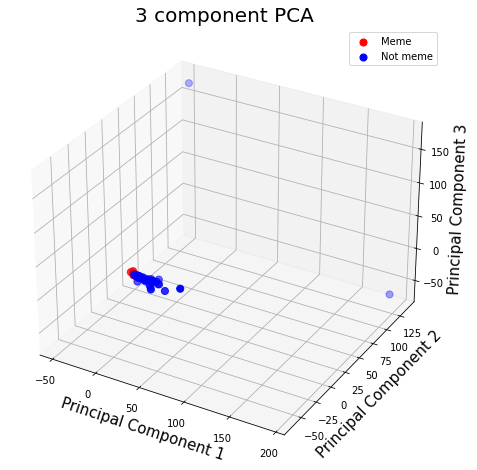

In [72]:

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , zs = finalDf.loc[indicesToKeep, 'principal component 3']
               , c = color
               , s = 50)
ax.legend(["Meme", "Not meme"])
ax.grid()

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# load dataset into Pandas DataFrame
df = pd.read_csv ("coin_text")   #read the csv file (put ‘r’ before the path string to address any special characters in the path, such as ‘\’). Don’t forget to put the file name at the end of the path + “.csv”
#print (df)

memes = df[df["label"] == 0]
not_memes = df[df["label"] == 1]

#separating features
memes_x = memes.iloc[:, 2:]
not_memes_x = not_memes.iloc[:, 2:]

#separating target
memes_y = memes.loc[:, ["label"]]
not_memes_y = not_memes.loc[:, ["label"]]

#standardizing features
memes_x = StandardScaler().fit_transform(memes_x)
not_memes_x = StandardScaler().fit_transform(not_memes_x)


print(memes_x)
print(not_memes_x)
pca = PCA(n_components=3)
#pc = [memes_x, not_memes_x]
pc = np.concatenate((memes_x, not_memes_x))
principalComponents = pca.fit_transform(pc)


principalDf = pd.DataFrame(data = principalComponents
, columns = [‘principal component 1’, ‘principal component 2’, ‘principal component 3’])

finalDf = pd.concat([principalDf, df[[‘label’]]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel(‘Principal Component 1’, fontsize = 15)
ax.set_ylabel(‘Principal Component 2’, fontsize = 15)
#ax.set_zlabel(‘Principal Component 3’, fontsize = 15)
ax.set_title(‘2 component PCA’, fontsize = 20)
targets = [0, 1]
colors = [‘r’, ‘g’, ‘b’]
for target, color in zip(targets,colors):
    indicesToKeep = finalDf[‘label’] == target
    ax.scatter(finalDf.loc[indicesToKeep, ‘principal component 1’]
               , finalDf.loc[indicesToKeep, ‘principal component 2’]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [50]:
gecko = pd.read_csv("gecko_9_labeled.csv")
gecko = gecko.drop(columns=["num_holders", "whitepaper"])
gecko2 = gecko.dropna()
gecko2.head(25)

,name,symbol,price,volume,mkt_cap,coingecko_rank,vol / mkt_cap,dominance,coingecko_likes,fully_diluted_valuation,meme_coin
0,Bitcoin,BTC,33068.000000,2.373029e+10,6.323045e+11,1.0,0.038,0.415547,559287.0,6.967013e+11,-1
2,Tether,USDT,1.000000,4.973612e+10,6.252556e+10,3.0,0.795,0.041091,93977.0,6.236742e+10,-1
3,Binance Coin,BNB,315.550000,1.198426e+09,4.860686e+10,4.0,0.025,0.031944,257025.0,5.399287e+10,-1
4,Cardano,ADA,1.310000,1.463115e+09,4.304068e+10,5.0,0.034,0.028286,355233.0,5.897322e+10,-1
5,XRP,XRP,0.629109,2.034465e+09,2.930633e+10,6.0,0.069,0.019260,276676.0,6.310059e+10,-1
7,USD Coin,USDC,0.998819,2.605101e+09,2.614398e+10,8.0,0.100,0.017182,30331.0,2.636945e+10,-1
8,Polkadot,DOT,14.840000,5.638659e+08,1.577563e+10,9.0,0.036,0.010368,231864.0,1.618375e+10,-1
9,Uniswap,UNI,19.450000,3.410523e+08,1.090572e+10,10.0,0.031,0.007167,137846.0,1.951095e+10,-1
10,Binance USD,BUSD,0.998957,2.705859e+09,1.072773e+10,11.0,0.252,0.007050,23652.0,1.034587e+10,-1
11,Bitcoin Cash,BCH,30.770000,3.537503e+09,9.474615e+09,12.0,0.373,0.006227,117065.0,1.508355e+10,-1


In [33]:
meme_coins = gecko[gecko["meme_coin"] == 1]
meme_coins.describe()

,price,volume,mkt_cap,coingecko_rank,vol / mkt_cap,dominance,coingecko_likes,fully_diluted_valuation,meme_coin
count,2.900000e+01,5.100000e+01,2.000000e+01,20.000000,20.000000,2.000000e+01,51.000000,2.700000e+01,51.0
mean,8.020226e+00,6.213642e+07,1.661300e+09,1073.850000,0.053050,1.091796e-03,8228.509804,3.631992e+08,1.0
std,3.876402e+01,3.925477e+08,6.482627e+09,707.081643,0.065901,4.260343e-03,39329.326290,1.740036e+09,0.0
min,2.673000e-09,7.229000e+01,3.300250e+05,7.000000,0.002000,2.169000e-07,21.000000,2.830061e+04,1.0
25%,1.513895e-03,6.604275e+03,1.378561e+06,475.000000,0.011250,9.059500e-07,95.000000,1.364115e+06,1.0
50%,3.434029e-02,1.153400e+05,6.726006e+06,997.000000,0.031000,4.420300e-06,284.000000,7.682000e+06,1.0
75%,7.912620e-01,1.034518e+06,3.578673e+07,1660.250000,0.068250,2.351880e-05,1301.500000,5.142475e+07,1.0
max,2.093700e+02,2.792551e+09,2.894527e+10,2209.000000,0.275000,1.902266e-02,273393.000000,9.067280e+09,1.0


array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'volume'}>,
        <AxesSubplot:title={'center':'mkt_cap'}>],
       [<AxesSubplot:title={'center':'coingecko_rank'}>,
        <AxesSubplot:title={'center':'vol / mkt_cap'}>,
        <AxesSubplot:title={'center':'dominance'}>],
       [<AxesSubplot:title={'center':'coingecko_likes'}>,
        <AxesSubplot:title={'center':'fully_diluted_valuation'}>,
        <AxesSubplot:title={'center':'meme_coin'}>]], dtype=object)

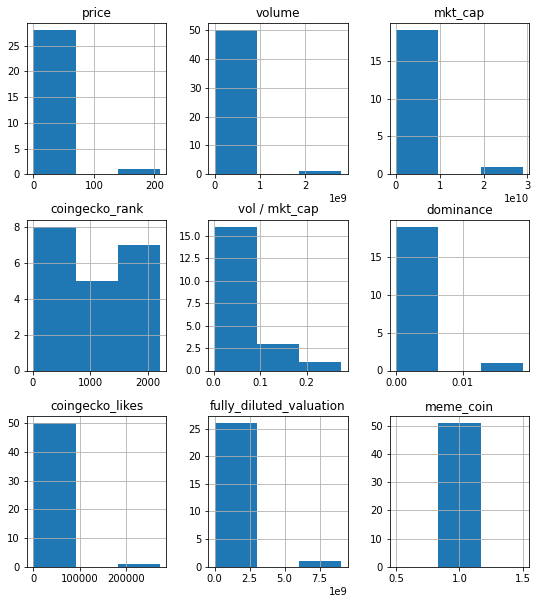

In [40]:
meme_coins.hist(bins=3,figsize=(9,10))

In [42]:
gecko2.corr()

,price,volume,mkt_cap,coingecko_rank,vol / mkt_cap,dominance,coingecko_likes,fully_diluted_valuation,meme_coin
price,1.000000,0.088843,0.182968,-0.040051,-0.002186,0.182968,0.088379,0.003910,-0.008044
volume,0.088843,1.000000,0.517788,-0.069936,0.001553,0.517788,0.360164,0.017548,-0.003774
mkt_cap,0.182968,0.517788,1.000000,-0.058806,-0.000908,1.000000,0.609912,0.035633,-0.003047
coingecko_rank,-0.040051,-0.069936,-0.058806,1.000000,0.046801,-0.058806,-0.313698,-0.024725,-0.015374
vol / mkt_cap,-0.002186,0.001553,-0.000908,0.046801,1.000000,-0.000908,-0.006695,-0.000773,-0.002242
dominance,0.182968,0.517788,1.000000,-0.058806,-0.000908,1.000000,0.609912,0.035633,-0.003047
coingecko_likes,0.088379,0.360164,0.609912,-0.313698,-0.006695,0.609912,1.000000,0.018469,-0.014580
fully_diluted_valuation,0.003910,0.017548,0.035633,-0.024725,-0.000773,0.035633,0.018469,1.000000,-0.002701
meme_coin,-0.008044,-0.003774,-0.003047,-0.015374,-0.002242,-0.003047,-0.014580,-0.002701,1.000000


In [58]:
train_set, test_set = train_test_split(gecko2.iloc[:,2:], test_size=0.2,random_state=69)
pipe = make_pipeline(StandardScaler(), SVC(gamma="auto"))
y_train = train_set["meme_coin"]
x_train = train_set.drop(columns=["meme_coin"])

y_test = test_set["meme_coin"]
x_test = test_set.drop(columns=["meme_coin"])

pipe.fit(x_train, y_train)  # apply scaling on training data

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [61]:
y_pred = pipe.predict(x_test)
svm_scores = cross_val_score(pipe, x_train, y_train, cv=10)
svm_scores.mean()

0.9932182591623038